## II - Trabajo práctico

​

La carpeta Drive siguiente contiene una serie de datasets: https://drive.google.com/drive/folders/14bt3oF4tibthkxQee0-a_esveoPwrZtd?usp=sharing

​

Cada dataset contiene noticias de prensa publicadas por medios chilenos entre Febrero 2017 y Febrero 2018. Cada dataset fue generado buscando una palabra clave específica, por ejemplo :'feminismo', 'corrupción', 'educación', 'mapuche', 'tecnología', etc.

​

El trabajo práctico consiste en:

- seleccionar 1 dataset. Por ejemplo: 'tecnología'

- aplicar una metodología basada en LDA para conocer cuáles son los tópicos conversados por los medios cuándo se habla de 'tecnología'. 

**Resumen**

1. Importar el dataset
1. Preparar las **stopwords** y ajustar el dataset (columna en particular) a tratar
1. **Tokenizar** (frases->lista de palabras) y limpieza (- signos de puntuación, espacios)
1. Creación de modelos **Bigram** (dos palabras que aparecen frecuentemente juntas) y **Trigram** 
1. Eliminar stopwords, **generar bigrams** y **lemmatizar** (conservando solo sustantivos, adjetivos, verbos y adverbios) en ese orden (secuencial)
1. Crear el **diccionario** (mapeo del id de las palabras a las palabras) y el **corpus** (mapeo del id de las palabras y su frecuencia)  necesarios para el **modelo de tópicos** (entradas para el modelo LDA)
1. Construir el **modelo de tópicos** o Modelo LDA (proceso de entrenamiento donde se entrega ademas del diccionario y corpus, el **número de topicos a extraer**)
1. **Evaluar** el modelo LDA construido
    1. Ver los topicos del modelo LDA (un tópico es combinación de palabras claves y cada palabra contribuye un peso al tema)
    1. Calcular metricas de **Perplejidad** (< mejor) y **coherencia** de los tópicos (> mejor)
    1. Encontrar el número optimo de tópicos (construir muchos modelos LDA con diferentes numeros de topicos "k" y elegir el con mayor coherencia)
    1. Tópico dominante en cada frase o documento
    1. Documento más representativo para cada tópico
    1. Distribución de topicos en el dataset

**Dudas**

Bigrams
"Manera más rápida de obtener una sentencia apaleada como un trigrama / bigrama" => queremos distingir palabras de bigramas y trigramas?

Los nombres cuentan como bigramas?

Porque no estamos aplicando lo de los bigramas en el codigo...

--

La elección de una "k" que marca el final de un rápido crecimiento de la coherencia temática suele ofrecer temas significativos e interpretables. Escoger un valor aún mayor puede a veces proporcionar subtópicos más granulares.

Si ve que las mismas palabras clave se repiten en varios temas, es probable que sea una señal de que la 'k' es demasiado grande.


In [1]:
import nltk; nltk.download('stopwords')

import spacy

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner']) # Cargamos modelos para procesar textos (noticias) en español
# (Notebook1)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/eidepozo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

### 1. Importar el dataset

In [3]:
DATASET_CSV="MAD_educacion1.csv"

df = pd.read_csv(DATASET_CSV,sep='|',error_bad_lines=False,header=None)
df.columns = ['fecha', 'fuente', 'titular', 'contenido']
df.head()

fecha            fuente  \
0  2017-06-01 23:15:03         el_dinamo    
1  2017-03-02 19:23:15          RedMiVoz    
2  2017-02-28 09:28:02    ElPeriscopioCL    
3  2017-02-28 13:25:24      El_Ciudadano    
4  2017-02-25 17:53:03            biobio    

                                             titular  \
0   Nicolás Maduro se comprometió a someter a un ...   
1   [Opinión] Porfirio Díaz, Evo Morales y la ree...   
2   Carolina Goic destaca las diferencias que la ...   
3   » Navarrete niega que tensión entre DC y PC p...   
4   Pizarro insta al PC a dar explicaciones por d...   

                                           contenido  
0   El presidente Nicolás Maduro se comprometió a...  
1   La reelección está íntimamente ligada al caud...  
2   Síguenos en: La presidenta del partido alzó l...  
3   Luego de la reunión del comité político de la...  
4   Desde la Democracia Cristiana siguen cuestion...

In [4]:
#df = df.head(1000) # acotar analisis

### 2. Preparar las palabras Stop-Words y ajustar el dataset

In [5]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use']) 
# podemos agregar palabras que encontremos (post-analisis) y que no entregen valor para determinar el topico


In [6]:
#print(stop_words)

In [7]:
# Convert to list
data = df.contenido.values.tolist() # sobre la columna noticia que deberia contener los mayores indicios del topico

#data = [re.sub('\S*@\S*\s?', '', sent) for sent in data] # pueden aplicarse expresiones regulares para eliminar
# palabras comunes como en el caso del foro (Notebook2), decidi no aplicarlo

pprint(data[:1])

[' El presidente Nicolás Maduro se comprometió a someter a un referéndum la '
 'nueva Constitución que surja de la Asamblea Constituyente y así responder a '
 'las críticas surgidas desde la Fiscalía General, la cual calificó el proceso '
 'popular como “un retroceso para la democracia”. Ante esto, Maduro recalcó '
 'que “la nueva Constitución saldrá a referendo consultivo para que sea el '
 'pueblo el que diga si está de acuerdo o no está de acuerdo. Y saldrán los '
 'mismos de siempre a llamar a votar no. Los derrotaremos”. Esto luego que la '
 'titular del Ministerio Público, Luisa Ortega, llegará al Tribunal Supremo de '
 'Justicia (TSJ) para pedir una “aclaratoria” de la Sala Constitucional, la '
 'cual respaldó el método propuesto por Maduro para elegir a los miembros de '
 'la Asamblea Nacional Constituyente. Y es que para la fiscal general, “se '
 'elimina la democracia participativa y protagónica, lo que le costó mucho al '
 'pueblo venezolano”. “Nosotros aprobamos la Constitu

Se debe **tokenizar** y **lematizar** cada frase para aplicar de mejor forma **LDA** (Latent Dirichlet Allocation) y extraer asi los tópicos de nuestro dataset.


### 3. Tokenizar en palabras y limpieza
Convertiremos cada frase en una lista de palabras, eliminando los signos de puntuación y los caracteres innecesarios por completo.

El <code>simple_preprocess()</code> de Gensim es comodo para esto.

In [8]:
# Tokenizar en palabras
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['el', 'presidente', 'nicolas', 'maduro', 'se', 'comprometio', 'someter', 'un', 'referendum', 'la', 'nueva', 'constitucion', 'que', 'surja', 'de', 'la', 'asamblea', 'constituyente', 'asi', 'responder', 'las', 'criticas', 'surgidas', 'desde', 'la', 'fiscalia', 'general', 'la', 'cual', 'califico', 'el', 'proceso', 'popular', 'como', 'un', 'retroceso', 'para', 'la', 'democracia', 'ante', 'esto', 'maduro', 'recalco', 'que', 'la', 'nueva', 'constitucion', 'saldra', 'referendo', 'consultivo', 'para', 'que', 'sea', 'el', 'pueblo', 'el', 'que', 'diga', 'si', 'esta', 'de', 'acuerdo', 'no', 'esta', 'de', 'acuerdo', 'saldran', 'los', 'mismos', 'de', 'siempre', 'llamar', 'votar', 'no', 'los', 'derrotaremos', 'esto', 'luego', 'que', 'la', 'titular', 'del', 'ministerio', 'publico', 'luisa', 'ortega', 'llegara', 'al', 'tribunal', 'supremo', 'de', 'justicia', 'tsj', 'para', 'pedir', 'una', 'aclaratoria', 'de', 'la', 'sala', 'constitucional', 'la', 'cual', 'respaldo', 'el', 'metodo', 'propuesto', 'por

### 4. Creación de modelos Bigram y Trigram

Los bigramas son dos palabras que aparecen frecuentemente juntas en el documento. Los trigramas son 3 palabras que ocurren con frecuencia.

Por encima solo encontre casos con anuncios y publicidad de sitios web como: 'corresponsal_iniciar_sesion_sitio' y 'bligoo.com'

Gensim puede construir e implementar los bigrams, trigramas, cuadrantes y más. Los dos argumentos importantes para las Frases son min_count y threshold. Cuanto más altos sean los valores de estos parámetros, más difícil será que las palabras se combinen con bigrams.

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[1]]])

['la', 'reeleccion', 'esta', 'intimamente', 'ligada', 'al', 'caudillismo', 'tan', 'nocivo', 'para', 'nuestros_pueblos', 'la', 'reeleccion', 'presidencial', 'es', 'un', 'tema', 'muy', 'delicado', 'para', 'la', 'salud', 'de', 'la', 'democracia', 'continental', 'me_refiero', 'la', 'democracia', 'aceptada', 'la', 'verdadera', 'democracia', 'la', 'democracia', 'de', 'la', 'carta', 'democratica', 'interamericana', 'de', 'la', 'oea', 'el', 'instrumento', 'mas', 'moderno', 'de', 'la', 'democracia', 'en', 'el', 'mundo', 'la', 'reeleccion', 'esta', 'intimamente', 'ligada', 'al', 'caudillismo', 'tan', 'nocivo', 'para', 'nuestros_pueblos', 'que', 'florece', 'en', 'estados', 'que', 'tienen', 'democracias', 'menos', 'desarrolladas', 'endebles', 'estructuras', 'institucionales', 'blogjimi', 'para', 'desgracia', 'nuestra', 'latinoamerica', 'es', 'el', 'continente', 'de', 'los', 'caudillos', 'el', 'caso', 'del', 'caudillo', 'mexicano', 'porfirio', 'diaz', 'quizas', 'sea', 'el', 'mas', 'dramatico', 'de'

### 5. Eliminar Stop-words, generar bigrams y lemmatizar

El modelo bigrams está listo. Definiremos las funciones para **eliminar** los stop-words, hacer bigrams y lemmatización y llamarlas secuencialmente.

In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

#def make_trigrams(texts):
#    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Llamamos a la funciones en el orden:

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
#data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [12]:
print(data_lemmatized[:1])

[['presidente', 'nicolas', 'madurar', 'comprometio', 'someter', 'referendum', 'nuevo', 'constitucion', 'surgir', 'asamblea', 'constituyente', 'asi', 'responder', 'criticar', 'surgir', 'fiscalia', 'general', 'calificar', 'procesar', 'popular', 'retroceso', 'democracia', 'madurar', 'recalcar', 'nuevo', 'constitucion', 'saldra', 'referendo', 'consultivo', 'poblar', 'decir', 'acordar', 'acordar', 'saldran', 'siempre', 'votar', 'derrotar', 'luego', 'titular', 'ministerio', 'publicar', 'luisa', 'ortega', 'llegar', 'tribunal', 'supremo', 'justicia', 'pedir', 'aclaratorio', 'salar', 'constitucional', 'respaldar', 'metodo', 'proponer', 'madurar', 'elegir', 'miembro', 'asamblea', 'nacional', 'constituyente', 'fiscal', 'general', 'eliminar', 'democracia', 'participativo', 'protagonica', 'costo', 'poblar', 'venezolano', 'aprobar', 'constitucion', 'republica', 'bolivariano', 'venezuela', 'procesar', 'participacion', 'consultar', 'poblar', 'venezolano', 'hacer', 'alusion', 'procesar', 'realizar']]


### 6. Crear el diccionario y el corpus necesarios para el modelo de tópicos

Las dos entradas principales al modelo de tópicos de LDA son el diccionario (id2word) y el corpus.

In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 3), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 3), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 3), (41, 1), (42, 1), (43, 3), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 2), (62, 1), (63, 1), (64, 2), (65, 1), (66, 1)]]


Gensim crea un identificador único para cada palabra del documento. El corpus producido que se muestra arriba es un mapeo de (word_id, word_frequency).

Por ejemplo, (0, 1) arriba implica que la palabra id 0 ocurre una vez en el primer documento. Del mismo modo, la palabra id 1 aparece dos veces y así sucesivamente.

Esto es usado como entrada por el modelo LDA.

Podemos pasar el id como una llave al diccionario, para ver a que palabra corresponde:

In [14]:
id2word[0]

'aclaratorio'

O bien, con una forma legible del propio corpus.

In [15]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('aclaratorio', 1),
  ('acordar', 2),
  ('alusion', 1),
  ('aprobar', 1),
  ('asamblea', 2),
  ('asi', 1),
  ('bolivariano', 1),
  ('calificar', 1),
  ('comprometio', 1),
  ('constitucion', 3),
  ('constitucional', 1),
  ('constituyente', 2),
  ('consultar', 1),
  ('consultivo', 1),
  ('costo', 1),
  ('criticar', 1),
  ('decir', 1),
  ('democracia', 2),
  ('derrotar', 1),
  ('elegir', 1),
  ('eliminar', 1),
  ('fiscal', 1),
  ('fiscalia', 1),
  ('general', 2),
  ('hacer', 1),
  ('justicia', 1),
  ('llegar', 1),
  ('luego', 1),
  ('luisa', 1),
  ('madurar', 3),
  ('metodo', 1),
  ('miembro', 1),
  ('ministerio', 1),
  ('nacional', 1),
  ('nicolas', 1),
  ('nuevo', 2),
  ('ortega', 1),
  ('participacion', 1),
  ('participativo', 1),
  ('pedir', 1),
  ('poblar', 3),
  ('popular', 1),
  ('presidente', 1),
  ('procesar', 3),
  ('proponer', 1),
  ('protagonica', 1),
  ('publicar', 1),
  ('realizar', 1),
  ('recalcar', 1),
  ('referendo', 1),
  ('referendum', 1),
  ('republica', 1),
  ('res

### 7. Construyendo el modelo de tópicos

Además del corpus y el diccionario <code>id2word</code>, debemos proporcionar el número de tópicos esperados <code>num_topics</code> (Gensim lo define como _el número de temas latentes solicitados que se extraerán del corpus_)

_chunksize_ es el número de documentos que se utilizarán en cada chunk de entrenamiento. _update_every_ determina la frecuencia con la que se deben actualizar los parámetros del modelo y _passes_ es el número total de pases de entrenamiento.
    
El proceso de entramiento del modelo de tópicos puede demorar unos minutos:

In [16]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## 8. Evaluar modelo LDA
### A. Palabras clave y pesos

El modelo LDA anterior está construido con 10 tópicos diferentes donde cada tópico es una combinación de palabras claves y cada palabra clave contribuye con un cierto peso al tema.

Podemos ver las palabras clave para cada tema y el peso (importancia) de cada palabra clave usando lda_model.print_topics()

In [17]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics(num_words=20))
doc_lda = lda_model[corpus]

[(0,
  '0.020*"democracia" + 0.011*"unir" + 0.010*"oea" + 0.009*"cuba" + '
  '0.009*"cubano" + 0.008*"diario" + 0.008*"general" + 0.007*"america" + '
  '0.006*"ano" + 0.006*"latino" + 0.006*"recibir" + 0.006*"secretario" + '
  '0.006*"decir" + 0.005*"carta" + 0.005*"partir" + 0.005*"noticiar" + '
  '0.005*"venezuela" + 0.005*"pais" + 0.005*"militar" + 0.005*"solo"'),
 (1,
  '0.032*"partir" + 0.024*"democracia" + 0.022*"cristiano" + 0.013*"candidato" '
  '+ 0.012*"nuevo" + 0.011*"goic" + 0.011*"presidencial" + 0.010*"dc" + '
  '0.010*"nacional" + 0.009*"diputar" + 0.009*"mayoria" + 0.009*"carolina" + '
  '0.007*"candidatura" + 0.007*"parlamentario" + 0.007*"senador" + '
  '0.007*"volver" + 0.007*"chile" + 0.006*"apoyar" + 0.006*"guillier" + '
  '0.006*"presidente"'),
 (2,
  '0.047*"ciudad" + 0.041*"newsletter" + 0.023*"recibir" + 0.022*"valor" + '
  '0.022*"suscribete" + 0.022*"mundo" + 0.021*"emol" + 0.021*"recibiras" + '
  '0.021*"propiedad" + 0.021*"pronto" + 0.021*"suceder" + 0.021*

__¿Cómo interpretar esto?__

El tópico 7 se representa como _0.103"venezuela" + 0.045"venezolano" + 0.042"madurar" + 0.028"dictadura" + ..._ etc.

Las ponderaciones reflejan la importancia de una palabra clave para ese tema.

Mirando estas palabras clave, ¿puedes adivinar cuál podría ser este tema? --> El estado actual de Venezuela (?)

Del mismo modo, ¿puede repasar las palabras claves de cada tópico evaluar cuál es el tópico?

### B. Calcular las métricas de perplejidad y coherencia de los tópicos

Las métricas de __perplejidad del modelo__ y la __coherencia de los tópicos__ proporcionan una medida para evaluar qué tan bueno es un modelo de tópico dado.

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.976979742099916

Coherence Score:  0.5185606997666924


### C. ¿Cómo encontrar el número óptimo de tópicos ?

El enfoque clásico para encontrar el número óptimo de tópicos consiste en construir muchos modelos LDA con diferentes valores de número de tópicos (k) y elegir el que dé el valor de coherencia más alto.

La elección de una "k" que marca el final de un rápido crecimiento de la coherencia temática suele ofrecer temas significativos e interpretables. Escoger un valor aún mayor puede a veces proporcionar subtópicos más granulares.

Si ve que las mismas palabras clave se repiten en varios temas, es probable que sea una señal de que la 'k' es demasiado grande.

Los valores de compute_coherence_values() (ver abajo) entrena múltiples modelos LDA y proporciona los modelos y sus correspondientes puntuaciones de coherencia.

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=3,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

Entrenar los distintos modelos puede necesitar varios minutos:

In [20]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=10, step=1)

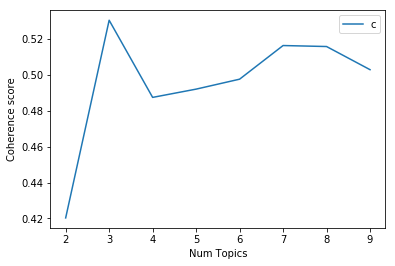

In [21]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4203
Num Topics = 3  has Coherence Value of 0.5304
Num Topics = 4  has Coherence Value of 0.4874
Num Topics = 5  has Coherence Value of 0.492
Num Topics = 6  has Coherence Value of 0.4976
Num Topics = 7  has Coherence Value of 0.5163
Num Topics = 8  has Coherence Value of 0.5158
Num Topics = 9  has Coherence Value of 0.5029


Si el puntaje de coherencia parece seguir aumentando, puede tener más sentido elegir el modelo que dio el puntaje más alto antes de aplanarse.

Para un analisis de 10 topicos la coherencia va en aumento, alcanzando un "maximo local" de coherencia en 3 topicos.

_Así que para los pasos siguientes voy a elegir el modelo con 2 temas en sí. (Notebook2)_

In [23]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.025*"democracia" + 0.009*"mas" + 0.008*"venezuela" + 0.007*"derecho" + '
  '0.006*"decir" + 0.006*"politica" + 0.006*"gobernar" + 0.005*"social" + '
  '0.005*"chile" + 0.005*"ano"'),
 (1,
  '0.022*"democracia" + 0.019*"partir" + 0.013*"cristiano" + 0.010*"chile" + '
  '0.009*"candidato" + 0.009*"presidente" + 0.008*"nuevo" + '
  '0.008*"presidencial" + 0.007*"pinera" + 0.006*"goic"'),
 (2,
  '0.015*"ciudad" + 0.015*"democracia" + 0.014*"newsletter" + 0.012*"chile" + '
  '0.011*"visitar" + 0.010*"recibir" + 0.009*"sitiar" + 0.009*"querer" + '
  '0.009*"mundo" + 0.008*"valor"')]


### D. Encontrar el tópico dominante en cada frase o documento

Una de las aplicaciones prácticas del modelo de tópicos es determinar de qué tópico trata un documento dado.

Para encontrar eso, encontramos el número del tópico que tiene el porcentaje más alto de contribución en ese documento.

La función format_topics_sentences() agrega esta información en una tabla presentable.

In [24]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        #row = sorted(row, key=lambda x: (x[1]), reverse=True)
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             0.0              0.6617   
1            1             0.0              0.8243   
2            2             1.0              0.9003   
3            3             1.0              0.9706   
4            4             1.0              0.7975   
5            5             0.0              0.9474   
6            6             1.0              0.6797   
7            7             0.0              0.6945   
8            8             1.0              0.9699   
9            9             1.0              0.9482   

                                            Keywords  \
0  democracia, mas, venezuela, derecho, decir, po...   
1  democracia, mas, venezuela, derecho, decir, po...   
2  democracia, partir, cristiano, chile, candidat...   
3  democracia, partir, cristiano, chile, candidat...   
4  democracia, partir, cristiano, chile, candidat...   
5  democracia, mas, venezuela, derecho, decir, po...   
6  democracia, partir, cristiano, chile, candidat...   
7  democracia, mas, venezuela, derecho, decir, po...   
8  democracia, partir, cristiano, chile, candidat...   
9  democracia, partir, cristiano, chile, candidat...   

                                                Text  
0   El presidente Nicolás Maduro se comprometió a...  
1   La reelección está íntimamente ligada al caud...  
2   Síguenos en: La presidenta del partido alzó l...  
3   Luego de la reunión del comité político de la...  
4   Desde la Democracia Cristiana siguen cuestion...  
5   Santiago Sábado, 25 de febrero de 2017 Actual...  
6   Diputados de la Nueva Mayoría pidieron al Gob...  
7   ¿Tienes cuenta? ¿No Tienes cuenta? Regístrate...  
8   Los presidentes de los partidos de la Nueva M...  
9   La mayor parte de los timoneles de la Nueva M...

### E. Encontrar el documento más representativo para cada tópico

A veces las palabras claves del tópico pueden no ser suficientes para entender de qué se trata el tema. Por lo tanto, para ayudar a comprender el tópico, se puede encontrar los documentos a los que un tópico dado ha contribuido más y deducir el tema leyendo ese documento.

In [25]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.9996   
1        1.0              0.9993   
2        2.0              0.9838   

                                            Keywords  \
0  democracia, mas, venezuela, derecho, decir, po...   
1  democracia, partir, cristiano, chile, candidat...   
2  ciudad, democracia, newsletter, chile, visitar...   

                                                Text  
0   Otras publicaciones del autor: Cristián Villa...  
1   Valparaíso 92.5 FM   Santiago 92.1 FM   San F...  
2   Ayer El portavoz del Departamento de Estado d...

### F. Distribución de tópicos en el dataset

Finalmente, queremos entender el volumen y la distribución de los tópicos para juzgar la amplitud de la discusión. La siguiente tabla expone esa información.

In [26]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

Dominant_Topic                                     Topic_Keywords  \
0                0.0  democracia, mas, venezuela, derecho, decir, po...   
1                0.0  democracia, mas, venezuela, derecho, decir, po...   
2                1.0  democracia, partir, cristiano, chile, candidat...   
3                1.0  democracia, partir, cristiano, chile, candidat...   
4                1.0  democracia, partir, cristiano, chile, candidat...   
5                0.0  democracia, mas, venezuela, derecho, decir, po...   
6                1.0  democracia, partir, cristiano, chile, candidat...   
7                0.0  democracia, mas, venezuela, derecho, decir, po...   
8                1.0  democracia, partir, cristiano, chile, candidat...   
9                1.0  democracia, partir, cristiano, chile, candidat...   
10               0.0  democracia, mas, venezuela, derecho, decir, po...   
11               1.0  democracia, partir, cristiano, chile, candidat...   
12               0.0  democracia, mas, venezuela, derecho, decir, po...   
13               1.0  democracia, partir, cristiano, chile, candidat...   
14               1.0  democracia, partir, cristiano, chile, candidat...   
15               1.0  democracia, partir, cristiano, chile, candidat...   
16               1.0  democracia, partir, cristiano, chile, candidat...   
17               1.0  democracia, partir, cristiano, chile, candidat...   
18               1.0  democracia, partir, cristiano, chile, candidat...   
19               0.0  democracia, mas, venezuela, derecho, decir, po...   
20               0.0  democracia, mas, venezuela, derecho, decir, po...   
21               1.0  democracia, partir, cristiano, chile, candidat...   
22               1.0  democracia, partir, cristiano, chile, candidat...   
23               1.0  democracia, partir, cristiano, chile, candidat...   
24               0.0  democracia, mas, venezuela, derecho, decir, po...   
25               0.0  democracia, mas, venezuela, derecho, decir, po...   
26               0.0  democracia, mas, venezuela, derecho, decir, po...   
27               0.0  democracia, mas, venezuela, derecho, decir, po...   
28               0.0  democracia, mas, venezuela, derecho, decir, po...   
29               1.0  democracia, partir, cristiano, chile, candidat...   
...              ...                                                ...   
1820             0.0  democracia, mas, venezuela, derecho, decir, po...   
1821             2.0  ciudad, democracia, newsletter, chile, visitar...   
1822             0.0  democracia, mas, venezuela, derecho, decir, po...   
1823             0.0  democracia, mas, venezuela, derecho, decir, po...   
1824             1.0  democracia, partir, cristiano, chile, candidat...   
1825             2.0  ciudad, democracia, newsletter, chile, visitar...   
1826             1.0  democracia, partir, cristiano, chile, candidat...   
1827             1.0  democracia, partir, cristiano, chile, candidat...   
1828             1.0  democracia, partir, cristiano, chile, candidat...   
1829             2.0  ciudad, democracia, newsletter, chile, visitar...   
1830             1.0  democracia, partir, cristiano, chile, candidat...   
1831             1.0  democracia, partir, cristiano, chile, candidat...   
1832             1.0  democracia, partir, cristiano, chile, candidat...   
1833             1.0  democracia, partir, cristiano, chile, candidat...   
1834             1.0  democracia, partir, cristiano, chile, candidat...   
1835             1.0  democracia, partir, cristiano, chile, candidat...   
1836             1.0  democracia, partir, cristiano, chile, candidat...   
1837             1.0  democracia, partir, cristiano, chile, candidat...   
1838             1.0  democracia, partir, cristiano, chile, candidat...   
1839             1.0  democracia, partir, cristiano, chile, candidat...   
1840             1.0  democracia, partir, cristiano, chile, candidat...   
1841             1.0  democraci